In [1]:
import time
import numpy as np
import h5py
import hdf5plugin
import pandas as pd
import matplotlib as mpl
import matplotlib.colors as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from unyt import yr, Myr, kpc, arcsec, nJy, Mpc, Msun, erg, s, Hz
from astropy.cosmology import Planck18 as cosmo
from scipy import signal

from synthesizer.grid import Grid
from synthesizer.parametric import SFH, ZDist
from synthesizer.particle.stars import sample_sfhz
from synthesizer.parametric import Stars as ParametricStars
from synthesizer.particle.particles import CoordinateGenerator
from synthesizer.filters import Filter, FilterCollection
from synthesizer.sed import combine_list_of_seds

from synthesizer.load_data.load_camels import load_CAMELS_IllustrisTNG
from synthesizer.kernel_functions import Kernel

from synthesizer.conversions import lnu_to_absolute_mag

/var/folders/yn/_ch1_n7x7y1g91hrx1ljp5n80000gp/T/ipykernel_53148/2976919345.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# get grid for all galaxies
# gives grid of metalicity and age which is used to map on our camels galaxies
grid_name = "bc03-2016-Miles_chabrier-0.1,100.hdf5"
grid_dir = "/Users/am/Documents/CAMELS/data/grids"
grid = Grid(grid_name, grid_dir=grid_dir, read_lines=False)

In [5]:
# get gals
gals_025 = load_CAMELS_IllustrisTNG(
    "/Users/am/Documents/CAMELS/data/CV/CV_0",
    snap_name="snap_025.hdf5",
    fof_name="fof_subhalo_tab_025.hdf5",
)

print('Number of Galaxies in snap_025', len(gals_025))

cat_025 = '/Users/am/Documents/CAMELS/data/CV/CV_0/fof_subhalo_tab_025.hdf5'
# open file
f = h5py.File(cat_025, 'r')

# read different attributes of the header
boxSize_025 = f['Header'].attrs[u'BoxSize']/1e3 #Mpc/h
redshift_025 = f['Header'].attrs[u'Redshift']
print('BoxSize: ', boxSize_025)
print('redshift: ', redshift_025)

/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1938: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/Users/am/anaconda3/envs/allyenv/lib/python3.9/site-packages/unyt/array.py:1813: RuntimeWarning: divide by zero encountered in log10
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


Number of Galaxies in snap_025 18554
BoxSize:  25.0
redshift:  0.46525063335034633


In [6]:
# Filter galaxies to only include those with 100 or more star particles
## NEED TO ADD FILTER TO GET RID OF ANY GALAXIES WITH LESS THAN 100 star Particles!! This is the resolution limit!!
# Chris: when you load your galaxies in could you do a filter for those with at least 100 star particles? that's the resolution limit

gals_025 = [gal for gal in gals_025 if len(gal.stars.ages) >= 100]
len(gals_025)

370

In [7]:
spec_list = []
# Lets work with z=0 so gals_025
for i in gals_025:
    gal = i
    # get_spectra_incident An Sed object containing the stellar spectra
    spec = gal.stars.get_spectra_incident(grid)
    spec.get_fnu0()
    spec_list.append(spec)

In [8]:
spec_list

In [9]:
# combine
seds = combine_list_of_seds(spec_list)

In [13]:
# Need to use the grid lam, dont need to define wavelengths here: see codes here: http://svo2.cab.inta-csic.es/theory/fps/index.php?id=Swift/UVOT.UVM2&&mode=browse&gname=Swift&gname2=UVOT#filter
# need to use transmission NOT area
# Get for XMM
fil_uvm2_XMM = Filter("XMM/OM.UVM2_filter", new_lam=grid.lam)

# now get for UVOT
fil_uvm2_UVOT = Filter("Swift/UVOT.UVM2_fil", new_lam=grid.lam) # changed from new_lam=lams_uvot to grid.lam and get 0 transmission, but warning sign is back

# what is a top hat filter?
filt1 = Filter("top_hat/filter.1", lam_min=1400, lam_max=1600, new_lam=grid.lam)

# 0 = TopHat, 1 = XMM, 2= Swift
filt_lst = [filt1, fil_uvm2_XMM, fil_uvm2_UVOT]

# get filters in combined array to apply to all galaxies
combined_filters = FilterCollection(
    filters=filt_lst, new_lam=grid.lam
)


In [33]:
seds.lnu # rest frame lumd


unyt_array([[9.48778970e+01, 5.98721742e+03, 1.57493127e+05, ...,
        7.86944963e+22, 3.49753527e+22, 1.55446080e+22],
       [3.41879710e+01, 2.14967687e+03, 5.41630036e+04, ...,
        4.07641120e+22, 1.81173940e+22, 8.05217862e+21],
       [1.10886180e+13, 1.24722999e+14, 6.60841004e+14, ...,
        1.36464522e+22, 6.06509350e+21, 2.69559836e+21],
       ...,
       [2.10972560e+00, 7.73253084e+01, 1.65095740e+03, ...,
        9.46270178e+20, 4.20563986e+20, 1.86917826e+20],
       [2.72511406e+00, 6.24663452e+01, 1.12763281e+03, ...,
        7.25927352e+20, 3.22634568e+20, 1.43393218e+20],
       [8.45604241e-01, 5.28467724e+01, 1.27485897e+03, ...,
        5.40127386e+20, 2.40056728e+20, 1.06691932e+20]], 'erg/(Hz*s)')

In [34]:
seds.get_photo_luminosities(combined_filters)


In [35]:
seds.photo_luminosities.photo_luminosities


unyt_array([[2.09649536e+28, 4.36932199e+26, 1.72549356e+29, ...,
        3.59499579e+28, 6.26817942e+27, 1.04369284e+27],
       [3.56291909e+28, 3.75542211e+27, 1.65501501e+29, ...,
        2.81911303e+28, 5.91445211e+27, 1.53106477e+27],
       [3.46846380e+28, 3.47520839e+27, 1.66772151e+29, ...,
        2.86276682e+28, 5.93898903e+27, 1.51519755e+27]], 'erg/(Hz*s)')

Absolute magnitude is defined to be the apparent magnitude an object would have if it were located at a distance of 10 parsecs.
In astronomy, absolute magnitude (M) is a measure of the luminosity of a celestial object on an inverse logarithmic astronomical magnitude scale.

In [54]:
abs_mag = lnu_to_absolute_mag(seds.photo_luminosities.photo_luminosities)
print(abs_mag)

[[-19.20895738 -15.00625774 -21.49750597 ... -19.79446858 -17.89807616
  -15.95165437]
 [-19.78473751 -17.34186951 -21.45222745 ... -19.53050384 -17.83500891
  -16.36770652]
 [-19.75556553 -17.25767474 -21.46053144 ... -19.54718755 -17.83950392
  -16.35639576]]


In [45]:
abs_mag_th = abs_mag[0]
abs_mag_th

array([-19.20895738, -15.00625774, -21.49750597, -13.6185329 ,
       -18.99647489, -13.38352105, -18.00848946, -15.73602301,
       -19.22991786, -12.03574737, -12.39996504, -15.38162374,
       -12.00975871, -11.20898148, -10.63699474, -11.57931906,
       -10.32452111, -11.16961115, -10.27848304,  -9.78516381,
       -16.78587317, -17.29275743, -18.72316557, -19.56193167,
       -17.78650301, -19.4238571 , -19.01641671, -12.2831295 ,
       -17.34533727, -10.19607013, -17.84061657, -15.23952679,
       -18.98627624, -21.24646422, -19.87763749, -20.01738477,
       -15.91546973, -12.15149703, -10.28968106, -15.19599736,
       -19.11748873, -14.61302936, -14.08753201, -20.56769929,
       -19.76627142, -21.29203321, -20.43366933, -19.07120012,
       -16.87670463, -18.76362941, -14.73211171, -17.2692294 ,
       -18.56356131, -17.29863696, -12.37289766, -15.24843537,
       -19.51534985, -14.21261183, -20.02479692, -19.62475924,
       -18.90438378, -10.82008169, -21.68863284, -11.57

In [46]:
abs_mag_xmm = abs_mag[1]
abs_mag_xmm


array([-19.78473751, -17.34186951, -21.45222745, -16.02561888,
       -19.19350577, -15.00001933, -18.14834018, -17.05105335,
       -19.19703848, -14.56374404, -14.24348344, -16.50441772,
       -14.1356263 , -14.62906573, -13.87945524, -13.13296608,
       -13.83913377, -13.89525857, -12.87930543, -12.67037516,
       -18.50306961, -17.5898052 , -18.57352962, -19.47389031,
       -18.08487053, -19.38160478, -18.79700374, -14.61350127,
       -17.3301561 , -13.44294813, -18.25437444, -16.78881062,
       -19.18485195, -21.24550331, -19.82422976, -19.9256478 ,
       -16.41630419, -14.57744609, -13.43638466, -15.66965843,
       -19.81899697, -16.83470435, -17.56349516, -20.61304258,
       -19.6963605 , -21.2575496 , -20.37137763, -19.28232845,
       -17.27311161, -19.02069471, -16.83235528, -17.65326872,
       -18.70167042, -17.52451544, -14.90983614, -15.68742171,
       -19.70672326, -16.16661275, -20.02611402, -19.69989123,
       -18.8690971 , -14.08426711, -21.59969136, -14.45

In [47]:
abs_mag_swft = abs_mag[2]
abs_mag_swft

array([-19.75556553, -17.25767474, -21.46053144, -15.93585866,
       -19.19008456, -14.91820913, -18.14407445, -17.01993031,
       -19.20449282, -14.47816479, -14.15636076, -16.47692349,
       -14.04309285, -14.56088007, -13.80273822, -13.04900444,
       -13.76522438, -13.80242632, -12.78704856, -12.57604811,
       -18.43978985, -17.57072467, -18.58218428, -19.48358926,
       -18.0801711 , -19.38494801, -18.81319662, -14.53614646,
       -17.33076568, -13.36667268, -18.22356427, -16.71857428,
       -19.18063691, -21.25062376, -19.83148631, -19.93506498,
       -16.40729958, -14.51001329, -13.35913761, -15.65443806,
       -19.79561053, -16.75852742, -17.48238589, -20.61512243,
       -19.70722063, -21.26401875, -20.37873001, -19.28081133,
       -17.26621671, -19.00007691, -16.74982644, -17.64702098,
       -18.69859688, -17.51963711, -14.85749421, -15.66753316,
       -19.69735153, -16.0883592 , -20.02789363, -19.70105395,
       -18.87166574, -14.01016362, -21.6079497 , -14.39

In [19]:
# next steps, get luminosity function for these magnitudes
# co-moving volume: BoxSize_033 and redshift:
Vphys = boxSize_025**3
Vcom = Vphys * ((1+redshift_025)**3)
print(Vcom)


49153.65074662243


In [52]:

def compute_luminosity_function(magnitudes, bin_size=0.5, max_bins=None):
    """
    Compute the luminosity function from an array of absolute magnitudes.
    
    Parameters:
    - magnitudes: numpy.ndarray of absolute magnitudes
    - bin_size: size of the bins for the histogram (magnitude)
    - max_bins: maximum allowed number of bins to prevent memory errors
    
    Returns:
    - bin_centers: numpy.ndarray of the center of each bin
    - density: numpy.ndarray of the density of objects per bin
    """
    # Ensure magnitudes is a NumPy array
    magnitudes = np.array(magnitudes)
    
    # Calculate the number of bins; guard against too many bins
    num_bins = np.ceil((magnitudes.max() - magnitudes.min()) / bin_size).astype(int)
    if max_bins is not None and num_bins > max_bins:
        bin_size = (magnitudes.max() - magnitudes.min()) / max_bins
        num_bins = max_bins
    
    # Compute histogram with the adjusted bin size
    bin_edges = np.linspace(magnitudes.min(), magnitudes.max(), num_bins + 1)
    counts, _ = np.histogram(magnitudes, bins=bin_edges)
    
    density = counts
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    return bin_centers, density

def plot_luminosity_function(bin_centers, density):
    
    # Generate a single random color for all bars
    random_color = np.random.rand(3,)
    
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers, density, width=np.diff(bin_centers)[0], color=random_color, alpha=0.7)
    plt.xlabel('Absolute Magnitude')
    plt.ylabel('Number of Objects')
    plt.title('Luminosity Function')
    plt.grid(True)
    plt.show()



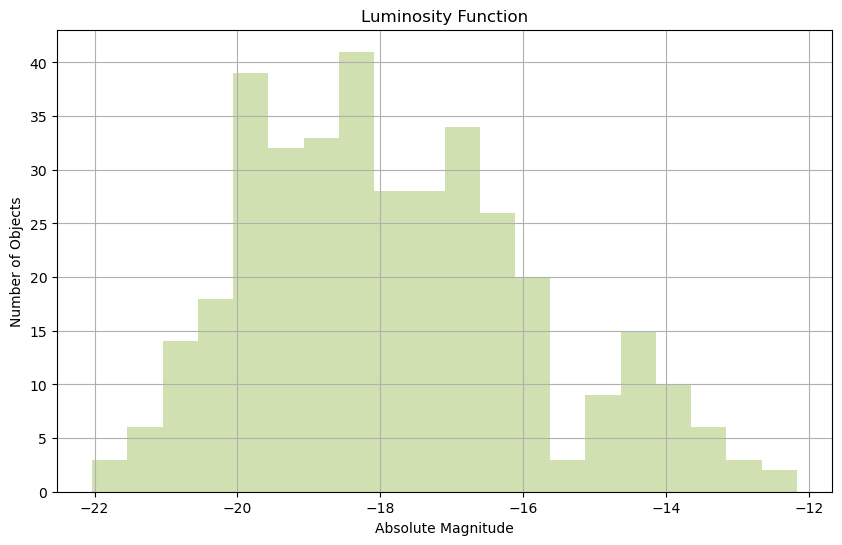

In [58]:
# Example usage
if __name__ == "__main__":
    # Example data
    #magnitudes = np.random.normal(-20, 1, 17176)  # Assuming these are the absolute magnitudes of galaxies
    magnitudes =abs_mag_xmm
    
    # Compute the luminosity function with a maximum of 100 bins
    bin_centers, density = compute_luminosity_function(magnitudes, bin_size=0.5, max_bins=100)
    
    # Plot the luminosity function
    plot_luminosity_function(bin_centers, density)



In [57]:


# To do : NOT CURRENTLY WORKNG, applying to class spec not object so trying without
# need to apply to all galaxies in the snap/subhalo catalogue
# once I've done that, can use the combine_list_of_seds to combine all of them and then apply the filter and get the luminosities from this.
# crate a list of the sed objects, then can 
# run this on lsit of seds and gets a single sed objects that contain all my luminosities.
# then can apply photometry and lnu to abs mag.

In [69]:
# Alternative method for LF:
# try this method again, but using AB mag instead of mass, and suply your own bins (up to -17, say)
def calc_df(ab_mag, volume, massBinLimits):

# OG:        hist, dummy = np.histogram(np.log10(mstar), bins = massBinLimits)
        hist, dummy = np.histogram(ab_mag, bins = massBinLimits)
        hist = np.float64(hist)
        phi = (hist / volume) / (massBinLimits[1] - massBinLimits[0])

        phi_sigma = (np.sqrt(hist) / volume) /\
                    (massBinLimits[1] - massBinLimits[0]) # Poisson errors

        return phi, phi_sigma, hist

In [70]:
# Define the bin edges for AB magnitudes
# Here, let's define bins from -25 to -17 in steps of 0.5 magnitude
massBinLimits = np.arange(-22, -16, 0.5)

phi, phi_sigma, hist = calc_df(abs_mag_xmm, Vcom, massBinLimits)

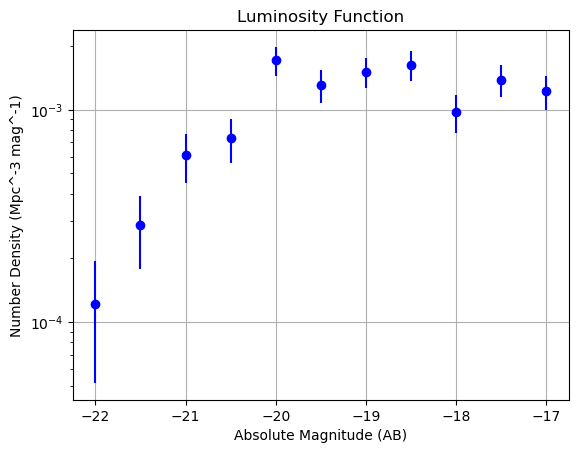

In [72]:
label_025 = 'z = ', redshift_025


# Plot the luminosity function
plt.errorbar(massBinLimits[:-1], phi, yerr=phi_sigma, fmt='o', color='blue')
plt.xlabel('Absolute Magnitude (AB)')
plt.ylabel('Number Density (Mpc^-3 mag^-1)')
plt.yscale('log')

plt.title('Luminosity Function')
plt.grid(True)
plt.show()